# Responsible AI: XAI GenAI project

## 0. Background



Based on the previous lessons on explainability, post-hoc methods are used to explain the model, such as saliency map, SmoothGrad, LRP, LIME, and SHAP. Take LRP (Layer Wise Relevance Propagation) as an example; it highlights the most relevant pixels to obtain a prediction of the class "cat" by backpropagating the relevance. (image source: [Montavon et. al (2016)](https://giorgiomorales.github.io/Layer-wise-Relevance-Propagation-in-Pytorch/))

<!-- %%[markdown] -->
![LRP example](images/catLRP.jpg)

Another example is about text sentiment classification, here we show a case of visualizing the importance of words given the prediction of 'positive':

![text example](images/textGradL2.png)

where the words highlight with darker colours indicate to be more critical in predicting the sentence to be 'positive' in sentiment.
More examples could be found [here](http://34.160.227.66/?models=sst2-tiny&dataset=sst_dev&hidden_modules=Explanations_Attention&layout=default).

Both cases above require the class or the prediction of the model. But:

***How do you explain a model that does not predict but generates?***

In this project, we will work on explaining the generative model based on the dependency between words. We will first look at a simple example, and using Point-wise Mutual Information (PMI) to compute the saliency map of the sentence. After that we will contruct the expereiment step by step, followed by exercises and questions.


## 1. A simple example to start with
Given a sample sentence: 
> *Tokyo is the capital city of Japan.* 

We are going to explain this sentence by finding the dependency using a saliency map between words.
The dependency of two words in the sentence could be measured by [Point-wise mutual information (PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information): 


Mask two words out, e.g. 
> \[MASK-1\] is the captial city of \[MASK-2\].


Ask the generative model to fill in the sentence 10 times, and we have:

| MASK-1      | MASK-2 |
| ----------- | ----------- |
|    tokyo   |     japan   |
|  paris  |     france    |
|  london  |     england    |
|  paris  |     france    |
|  beijing |  china |
|    tokyo   |     japan   |
|  paris  |     france    |
|  paris  |     france    |
|  london  |     england    |
|  beijing |  china |

PMI is calculated by: 

$PMI(x,y)=log_2⁡ \frac{p(\{x,y\}| s-\{x,y\})}{P(\{x\}|s-\{x,y\})P(\{y\}|s-\{x,y\})}$

where $x$, $y$ represents the words that we masked out, $s$ represents the setence, and $s-\{x,y\}$ represents the sentences tokens after removing the words $x$ and $y$.

In this example we have $PMI(Tokyo, capital) = log_2 \frac{0.2}{0.2 * 0.2} = 2.32$

Select an interesting word in the sentences; we can now compute the PMI between all other words and the chosen word using the generative model:
(Here, we use a longer sentence and run 20 responses per word.)
![](images/resPMI.png)


## 2. Preparation
### 2.1 Conda enviroment

```
conda env create -f environment.yml
conda activate xai_llm
```


### 2.2 Download the offline LLM

We use the offline LLM model from hugging face. It's approximately 5 GB.
Download it using the comman below, and save it under `./models/`.
```
huggingface-cli download TheBloke/openchat-3.5-0106-GGUF openchat-3.5-0106.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False
# credit to https://huggingface.co/TheBloke/openchat-3.5-0106-GGUF
```

## 3. Mask the sentence and get the responses from LLM
### 3.1 Get the input sentence

**Remember to change the anchor word index when changing the input sentence.**

In [ ]:
def get_input():
    # ideally this reads inputs from a file, now it just takes an input
    return input("Enter a sentence: ")
    
anchor_word_idx = 0 # the index of the interested word
prompts_per_word = 20 # number of generated responses  

sentence ="Tokyo is the capital of Japan"
sentence = sentence.lower()
print("Sentence: ", sentence)

### 3.2 Load the model

In [ ]:
from models.ChatModel import ChatModel
model_name = "openchat"
model = ChatModel(model_name)
print(f"Model: {model_name}")

### 3.3 Run the prompts and get all the responses


In [ ]:
from tools.command_generator import generate_prompts, prefix_prompt
from tools.evaluate_response import get_replacements
from tqdm import tqdm

def run_prompts(model, sentence, anchor_idx, prompts_per_word=20):
    prompts = generate_prompts(sentence, anchor_idx)
    all_replacements = []
    for prompt in prompts:
        replacements = []
        for _ in tqdm(
            range(prompts_per_word),
            desc=f"Input: {prompt}",
        ):
            response = model.get_response(
                prefix_prompt(prompt),
            ).strip()
            if response:
                replacement = get_replacements(prompt, response)
                if replacement:
                    replacements.append(tuple(replacement))
        if len(replacements) > 0:
            all_replacements.append(replacements)
    return all_replacements

all_responses = run_prompts(model, sentence, anchor_word_idx, prompts_per_word)

### 3.4 EXERCISE: compute the PMI for each word

$PMI(x,y)=log_2⁡ \frac{p(\{x,y\}| s-\{x,y\})}{P(\{x\}|s-\{x,y\})P(\{y\}|s-\{x,y\})}$

* Compute the $P(x)$, $P(y)$ and $P(x,y)$ first and print it out.
* Compute the PMI for each word.
* Visualize the result by coloring. Tips: you might need to normalize the result first. 


In [ ]:
import pandas as pd
from IPython.display import display, Markdown

def visualize_replacements(all_responses, sentence, anchor_word_idx):
    prompts = generate_prompts(sentence, anchor_word_idx)
    for i, replacements in enumerate(all_responses):
        prompt = prompts[i]
        data = []
        
        for j, replacement in enumerate(replacements):
            filled_prompt = prompt.replace("[MASK]", replacement[0], 1).replace("[MASK]", replacement[1], 1)
            data.append({
                "No.": j + 1,  # Add numbering for replacements
                "Filled Prompt": filled_prompt,
                "Replacements": f"({replacement[0]}, {replacement[1]})"
            })
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Display prompt with Markdown
        display(Markdown(f"### Prompt: `{prompt}`"))
        
        styled_df = df.style.hide(axis="index")
        display(styled_df)
        print("\n")  # Add spacing between prompts for better separation



visualize_replacements(all_responses, sentence, anchor_word_idx)

In [91]:
def strict_similarity(word1, word2, model = None):
    return int(word1 == word2)

### Debug Information for Sentence: `tokyo is the capital of japan`

,Word,"P({x}|s - {x, y})","P({y}|s - {x, y})","P({x, y}|s - {x, y})",PMI
0,tokyo,N/A,N/A,N/A,0.00
1,is,19/20,19/20,19/20,0.07
2,the,13/20,11/20,11/20,0.62
3,capital,17/20,17/20,17/20,0.23
4,of,18/20,16/20,16/20,0.15
5,japan,5/20,5/20,5/20,2.00


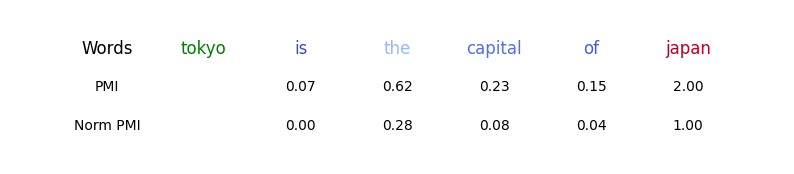

In [ ]:
import numpy as np
from collections import Counter


import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display, Markdown


from typing import Callable

def calculate_pmi(sentence, anchor_word_idx, all_responses, similarity_function: Callable[[str, str, object], int] = None, debug=False):
    words = sentence.split()
    anchor_word = words[anchor_word_idx]
    pmi_list = []
    if similarity_function is None:
        similarity_function = strict_similarity
    if debug:
        debug_data = [] 
    response_index = 0
    for word_index, word in enumerate(words):
        if word_index != anchor_word_idx:
            if anchor_word_idx < word_index:
                x_word, y_word = anchor_word, word
            else:
                x_word, y_word = word, anchor_word
            
            sum_of_X_similaritties = np.sum([similarity_function(x_word, response[0]) for response in all_responses[response_index]])
            sum_of_Y_similaritties = np.sum([similarity_function(y_word, response[1]) for response in all_responses[response_index]])
            sum_of_XY_similaritties = np.sum([similarity_function(x_word, response[0]) * similarity_function(y_word, response[1]) for response in all_responses[response_index]])
                
            
            total = len(all_responses[response_index])
            p_x = sum_of_X_similaritties / total
            p_y = sum_of_Y_similaritties / total
            p_xy = sum_of_XY_similaritties / total
            epsilon = 1e-10
            pmi = np.log2((p_xy+epsilon) / (p_x * p_y + epsilon))
            pmi_list.append(pmi)
            response_index += 1
            if debug:
                debug_data.append({
                    "Word": word,
                    f"P({{x}}|s - {{x, y}})": f"{sum_of_X_similaritties}/{total}",
                    f"P({{y}}|s - {{x, y}})": f"{sum_of_Y_similaritties}/{total}",
                    f"P({{x, y}}|s - {{x, y}})": f"{sum_of_XY_similaritties}/{total}",
                    "PMI": round(pmi, 2)
                })
        else:
            pmi_list.append(0)
            if debug:
                debug_data.append({
                    "Word": word,
                    f"P({{x}}|s - {{x, y}})": "N/A",
                    f"P({{y}}|s - {{x, y}})": "N/A",
                    f"P({{x, y}}|s - {{x, y}})": "N/A",
                    "PMI": 0
                })
    
    if debug:
        debug_df = pd.DataFrame(debug_data)
        display(Markdown(f"### Debug Information for Sentence: `{sentence}`"))
        display(debug_df)
    
    return pmi_list



import matplotlib.pyplot as plt
def visualize_pmi(pmi_list, sentence, anchor_word_idx):
    words = sentence.split()
    pmi_values = np.array(pmi_list)
    
    # Normalize the PMI values
    norm = plt.Normalize(pmi_values[np.arange(len(pmi_values)) != anchor_word_idx].min(), 
                         pmi_values[np.arange(len(pmi_values)) != anchor_word_idx].max())
    norm_pmi_values = norm(pmi_values)
    
    # Create a color map
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm_pmi_values)
    
    # Plot the words with colors based on PMI values
    plt.figure(figsize=(10, 2))
    for i, word in enumerate(words):
        color = 'green' if i == anchor_word_idx else colors[i]
        plt.text(i, 1, word, fontsize=12, ha='center', va='center', color=color)
        if i != anchor_word_idx:
            plt.text(i, 0.5, f"{pmi_values[i]:.2f}", fontsize=10, ha='center', va='center', color='black')
            plt.text(i, 0, f"{norm_pmi_values[i]:.2f}", fontsize=10, ha='center', va='center', color='black')
    
    # Add a quick legend
    plt.text(-1, 1, "Words", fontsize=12, ha='center', va='center', color='black')
    plt.text(-1, 0.5, "PMI", fontsize=10, ha='center', va='center', color='black')
    plt.text(-1, 0, "Norm PMI", fontsize=10, ha='center', va='center', color='black')
    
    plt.xlim(-2, len(words))
    plt.ylim(-0.5, 1.5)
    plt.axis('off')
    plt.show()

pmi_list = calculate_pmi(sentence, anchor_word_idx, all_responses, debug=True)
visualize_pmi(pmi_list, sentence, anchor_word_idx)


## 4. EXERCISE: Try more examples; maybe come up with your own. Report the results.

* Try to come up with more examples and, change the anchor word/number of responses, and observe the results. What does the explanation mean? Do you think it's a nice explanation? Why and why not? 
* What's the limitation of the current method? When does the method fail to explain? 

In [ ]:
def make_expermient(sentence, anchor_word_idx, prompts_per_word, model: ChatModel, similarity_function= None, debug=False):
    sentence = sentence.lower()
    all_responses = run_prompts(model, sentence, anchor_word_idx, prompts_per_word)
    if debug:
        # clean jupyter notebook output
        from IPython.display import clear_output
        clear_output()
        visualize_replacements(all_responses, sentence, anchor_word_idx)
    pmi_list = calculate_pmi(sentence, anchor_word_idx, all_responses, similarity_function, debug=debug)
    visualize_pmi(pmi_list, sentence, anchor_word_idx)

# make_expermient(sentence, anchor_word_idx, prompts_per_word, model)

In [ ]:
make_expermient("The capital of Japan is Tokyo", 5, 20, model, debug=True)

In [ ]:
make_expermient("The bank by the river is closed", 1, 20, model, debug=True)

In [ ]:
make_expermient("Despite the storm the ship sailed toward its goal", 4, 20, model, debug=True)

## 5. Bonus Exercises
### 5.1 Language pre-processing. 
In this exercise, we only lower the letters and split sentences into words; there's much more to do to pre-process the language. For example, contractions (*I'll*, *She's*, *world's*), suffix and prefix, compound words (*hard-working*). It's called word tokenization in NLP, and there are some Python packages that can do such work for us, e.g. [*TextBlob*](https://textblob.readthedocs.io/en/dev/). 


### 5.2 Better word matching
In the above example of
> Tokyo is the capital of Japan and a popular metropolis in the world.

, GenAI never gives the specific word 'metropolis' when masking it out; instead, sometimes it provides words like 'city', which is not the same word but has a similar meaning. Instead of measuring the exact matching of certain words (i.e. 0 or 1), we can also measure the similarity of two words, e.g. the cosine similarity in word embedding, which ranges from 0 to 1. 

In [89]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

def compute_similarity(word1, word2, model):
    # Encode words into embeddings
    vec1 = model.encode([word1])
    vec2 = model.encode([word2])
    
    # Compute cosine similarity
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity

embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
similarity = compute_similarity("Elo", "Elo", embedding_model)
print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.9999998807907104
